<a href="https://colab.research.google.com/github/gaba42/vision_pro_or_quest3/blob/main/Creating_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -Uqq fastai duckduckgo_search fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


## Step 1: Download images of apple and lg laptops

In [40]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastbook import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')
    return search_images_ddg(term, max_images=max_images)

<ipython-input-40-cb6fbc2f3748>:5: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  ddgs = DDGS()


In [41]:
# get URL from search
urls = search_images('apple vision pro', max_images=1)
urls[0]

Searching for 'apple vision pro'


'https://cdn.osxdaily.com/wp-content/uploads/2023/06/apple-vision-pro-ar-vr-headset-610x341.jpg'

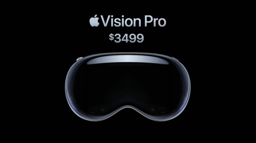

In [42]:
# download URL
from fastdownload import download_url
dest = 'apple.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for 'meta quest 3'


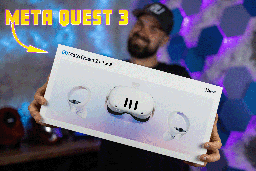

In [43]:
download_url(search_images('meta quest 3', max_images=1)[0], 'meta.jpg', show_progress=False)
Image.open('meta.jpg').to_thumb(256, 256)

In [44]:
# grab few examples of "sports cars" and "f1 cars" photos.
# save each group of photos to a different folder

searches = 'apple vision pro', 'meta quest 3'
path = Path('apple_or_meta')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} package'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} best buy'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'apple vision pro photo'
Searching for 'apple vision pro package'
Searching for 'apple vision pro best buy'
Searching for 'meta quest 3 photo'
Searching for 'meta quest 3 package'
Searching for 'meta quest 3 best buy'


## Step 2: Train model

In [45]:
# remove incorrectly downloaded photos

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

`DataLoaders` - an object that contains training set(used to create a model) and a validation set(used to check the accuracy of a model)

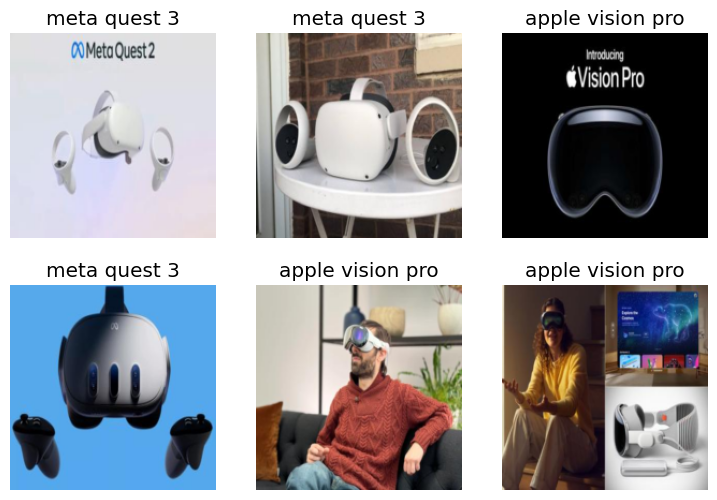

In [46]:
# use DataLoaders to train a model
# and use DataBlock to view sample images

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

`DataBlock` parameters

```python
blocks=(ImageBlock, CateogryBlock),
```
- The inputs to model are images, and the outputs are categories (in this case, "nascar" or "f1" cars).  
<br></br>

```python
get_items=get_image_files,
```
- To find all the inputs to the model, run the `get_image_files` function (which returns a list of all image files in a path).


<br></br>

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```
- Split the data into training and validation sets randomly, using 20% of the data for the validation set.

<br></br>


```python
get_y=parent_label,
```
- The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the foler they're in, which will be nascar or f1).

<br></br>

```python
item_tfms=[Resize(192, method='squish')]
```
- Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).


In [47]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.452036,0.826483,0.321429,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.424154,0.201737,0.071429,00:01
1,0.315114,0.049974,0.000000,00:00
2,0.226895,0.056777,0.035714,00:00


## Step 3: Use model

In [48]:
is_apple, _, probs = learn.predict(PILImage.create('apple.jpg'))
print(f"This is a: {is_apple}.")
print(f"Probability it's a apple vision pro: {probs[0]:.4f}")

This is a: apple vision pro.
Probability it's a apple vision pro: 0.9996
